# **Covid Image Classification Project**



### **Background Context:**
Covid-19 is a fast-growing disease that affects human health severely. Patients diagnosed with this condition suffer from lung infections. The medical community has recently released vaccines that have a slower effect in increasing immunity. This virus has impacted various countries\' human health and financial standards.

Deep learning algorithms have recently used image classification to identify medical images. Convolutional Neural Networks (CNN) can be widely utilized to identify COVID-19 to assist radiologists in medical analysis by classifying patients who are healthy, have viral pneumonia, or are affected by COVID using X-ray pictures of the lungs.
### **Objective:**

The aim of this project is two folds:

 - Build a deep learning model  to differentiate an X-ray image of a normal person from an unhealthy one.
 - Build an app using Streamlit for users to make predictions or inference using your model.

### **Data Description:**

- This dataset contains training set images of 3 classes which are converted into numpy arrays.
- The dataset comprises 3 classes:
 - COVID-19: The patient who is affected due to covid.
 - Viral Pneumonia: This is a viral fever that has similar characteristics to Covid but is not covid.
 - Normal- A healthy Person.
- The data file names are:
 - CovidImages.npy
 - CovidLabels.csv
- Due to the large volume of data, the images were converted to the CovidImages.npy file and the labels are also put into CovidLabels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.







In [1]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the necessary libraries**

In [2]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping                                              # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## **Reading the dataset**

In [4]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Files/Data/Covid_19/CovidImages.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Files/Data/Covid_19/CovidLabels.csv')

In [5]:
# Checking the labels

labels.head()

,Label
0,Viral Pneumonia
1,Viral Pneumonia
2,Viral Pneumonia
3,Viral Pneumonia
4,Viral Pneumonia


In [6]:
# Checking labels' unique values

np.unique(labels)

array(['Covid', 'Normal', 'Viral Pneumonia'], dtype=object)

## **Overview of the dataset**


Shape of the images and labels

In [7]:
print("The shape of the image is: ", images.shape)

print("The shape of the labels is: ", labels.shape)

The shape of the image is:  (251, 128, 128, 3)
The shape of the labels is:  (251, 1)


There are 251 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

## Plotting images using OpenCV and matplotlib

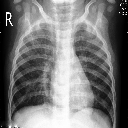

In [8]:
# Use openCV to show an image

cv2_imshow(images[2])

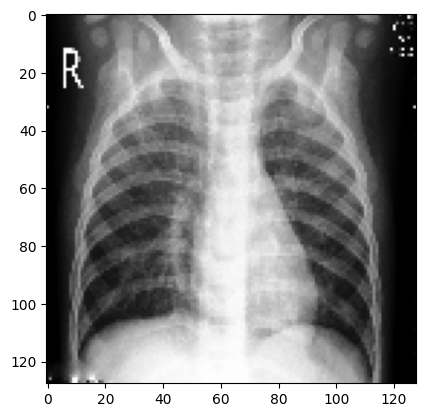

In [9]:
# Use Matplotlib to show the same image


plt.imshow(images[2])

In [10]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## **Exploratory Data Analysis**

In [11]:
# Checking unique plant seeds in the data

labels['Label'].nunique()

3

In [12]:
labels['Label'].value_counts()

Covid              111
Viral Pneumonia     70
Normal              70
Name: Label, dtype: int64

In [13]:
def plot_images(images,labels):
  num_classes=3                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaining the unique classes from y_train
  rows = 2                                                                        # Defining number of rows=2
  cols = 2                                                                        # Defining number of columns=2
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

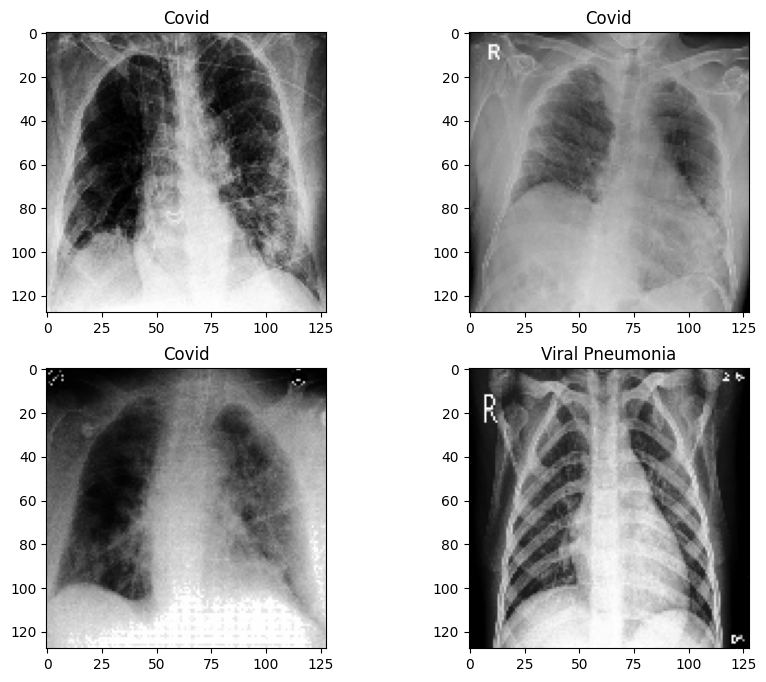

In [14]:
plot_images(images,labels)

<b> Checking for data imbalance

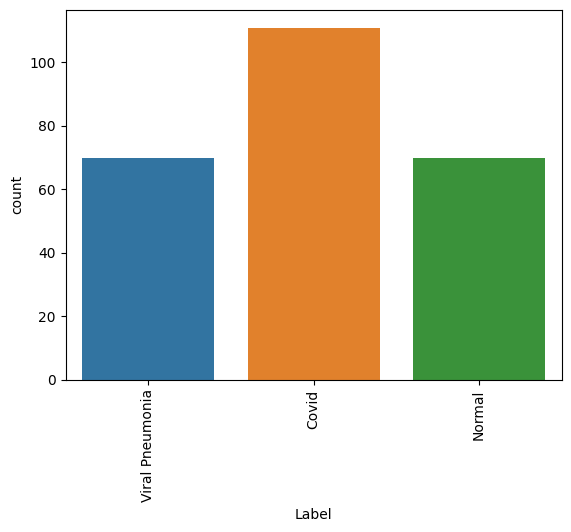

In [15]:
 sns.countplot(x ='Label', data = labels)
 plt.xticks(rotation=90);

- From the above plot, the dataset is slightly imbalanced.




### Resizing images
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [16]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

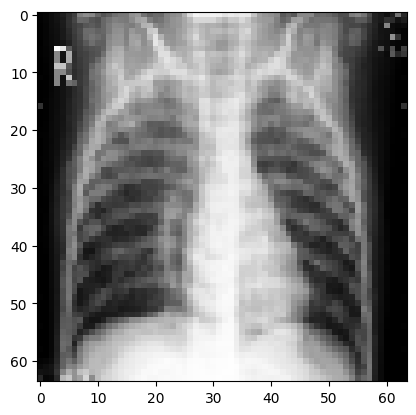

In [17]:
# show one image
plt.imshow(images_decreased[2]);

## Visualizing images using Gaussian Blur

In [18]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images)):
  # gb[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
  images_gb.append(cv2.GaussianBlur(images[i], ksize =(3,3),sigmaX =  0))


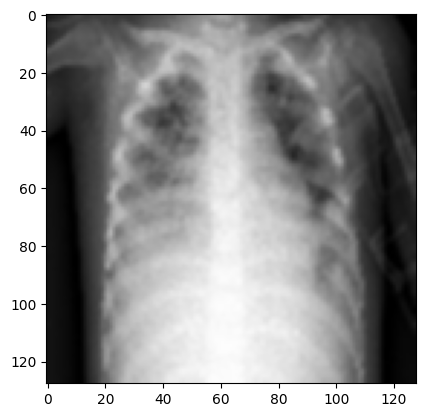

In [19]:
plt.imshow(images_gb[4]);

- It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

## **Splitting the dataset**

- Using the train_test_split() function from scikit-learn, the dataset will be split into train set(80%), test set(10%), and validation set(10%).


In [20]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [21]:
print("Train set shape is: ", X_train.shape,y_train.shape)
print("Validation set shape is: ", X_val.shape,y_val.shape)
print("Test set shape is: ", X_test.shape,y_test.shape)

Train set shape is:  (202, 64, 64, 3) (202, 1)
Validation set shape is:  (23, 64, 64, 3) (23, 1)
Test set shape is:  (26, 64, 64, 3) (26, 1)


## **Making the data compatible:**

- Convert labels from names to one hot vectors
- Normalizing the values


## Encoding the target labels

In [22]:
# Convert labels from names to one hot vectors.


from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

## Data Normalization
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [23]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


## **Model Building - Convolutional Neural Network (CNN)**


In [24]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [25]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Now, let's build a **CNN Model** with the following 2 main parts - <br>

1. **The Feature Extraction layers** which are comprised of convolutional and pooling layers.
2. **The Fully Connected classification layers** for prediction.<br><br>


In [26]:
# Creating an instance of the first sequential model
model = Sequential()

# Adding first conv layer with 32 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(32, (3, 3), padding = 'same', activation = "relu", input_shape = (64, 64, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D(2,2))


# Adding second conv layer with 64 filters and kernel size 3x3 , padding 'same'
model.add(Conv2D(64, (3, 3), padding = 'same', activation = "relu"))
# Adding max pooling to reduce the size of output of second conv layer
model.add(MaxPooling2D(2,2))


# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 128 neurons  and Dropout of 0.3
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.3))

# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(3, activation = "softmax"))

# Using Adam Optimizer
adam = Adam()

# Compile model
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

# Generating the summary of the model
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [27]:
# define early stopping layer


model_filename = "/content/drive/MyDrive/Files/Data/Covid_19/Model/covid.hdf5"
es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt = ModelCheckpoint(model_filename, verbose = 1, save_best_only = True)
callbacks_list = [chkpt, es]

### <b> Fitting the model on the train data

In [28]:
his_1 = model.fit(X_train_normalized, y_train_encoded, batch_size = 32,
                  epochs = 25, callbacks = callbacks_list, verbose = 2,
                  validation_data = (X_val_normalized,y_val_encoded))

Epoch 1/25

Epoch 1: val_loss improved from inf to 0.77818, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid.hdf5
7/7 - 12s - loss: 1.0284 - accuracy: 0.5198 - val_loss: 0.7782 - val_accuracy: 0.9130 - 12s/epoch - 2s/step
Epoch 2/25

Epoch 2: val_loss improved from 0.77818 to 0.41040, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid.hdf5
7/7 - 0s - loss: 0.7398 - accuracy: 0.7079 - val_loss: 0.4104 - val_accuracy: 0.9565 - 162ms/epoch - 23ms/step
Epoch 3/25

Epoch 3: val_loss improved from 0.41040 to 0.20844, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid.hdf5
7/7 - 0s - loss: 0.3987 - accuracy: 0.8713 - val_loss: 0.2084 - val_accuracy: 0.9565 - 170ms/epoch - 24ms/step
Epoch 4/25

Epoch 4: val_loss improved from 0.20844 to 0.18048, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid.hdf5
7/7 - 0s - loss: 0.3072 - accuracy: 0.8713 - val_loss: 0.1805 - val_accuracy: 0.9565 - 170ms/epoch - 24ms/step
Epo

### **Model Loss Evaluation**

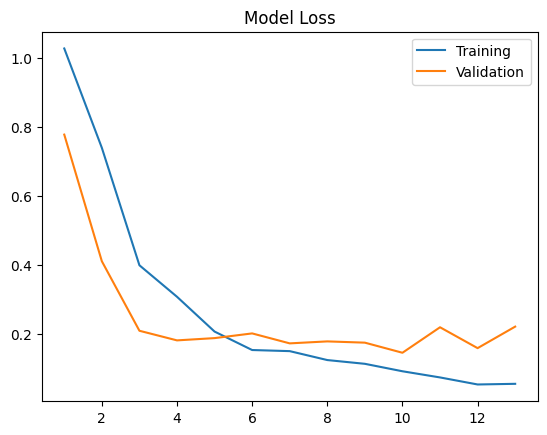

In [29]:
loss = his_1.history["loss"]
val_loss = his_1.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, label = "Training")
plt.plot(epochs, val_loss, label = "Validation")
plt.title("Model Loss")
plt.legend(loc = "best")
plt.show()

### **Model Accuracy Evaluation**

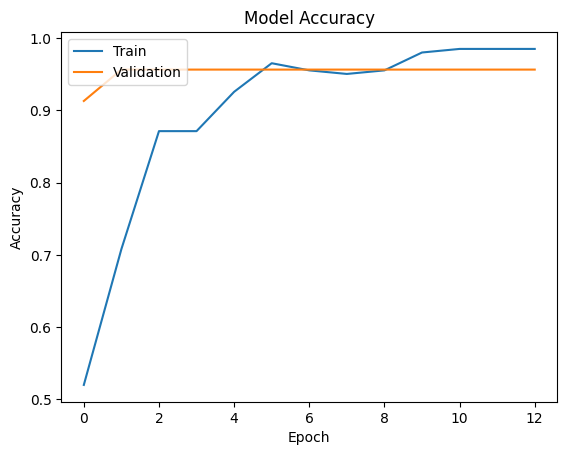

In [30]:
 plt.plot(his_1.history['accuracy'])
 plt.plot(his_1.history['val_accuracy'])
 plt.title('Model Accuracy')
 plt.ylabel('Accuracy')
 plt.xlabel('Epoch')
 plt.legend(['Train', 'Validation'], loc='upper left')
 plt.show()

**Observations:**


*   We can see from the above plot that **the training accuracy of the  model was very good just as the validation accuracy.**
*   The model seems to generalize on the data.






### **Evaluating the model on test data**

In [31]:
 accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 0s - loss: 0.0544 - accuracy: 1.0000 - 120ms/epoch - 120ms/step


### **Generating the predictions using test data**

In [32]:
 #Here we would get the output as probablities for each category
 y_pred=model.predict(X_test_normalized)

1/1 [==============================] - 0s 93ms/step


### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





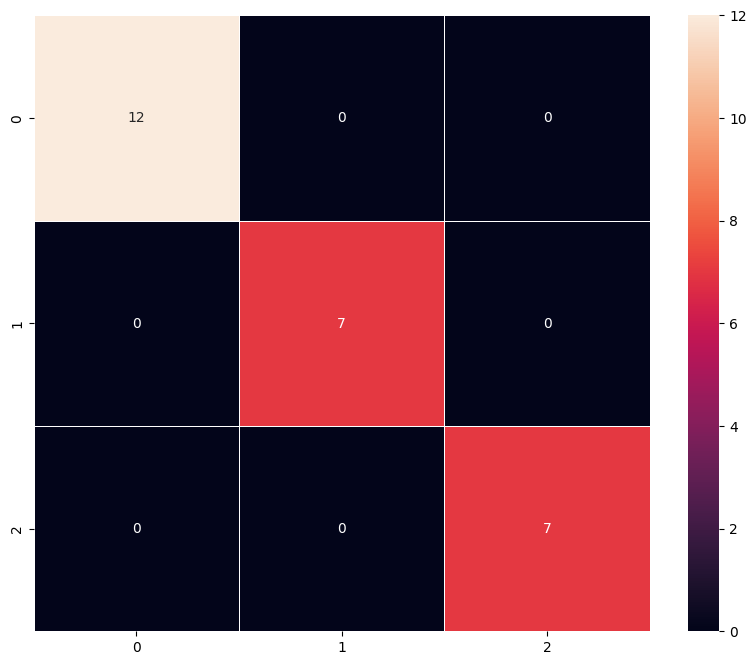

In [33]:
#Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- We observe that the classes were predicted correctly.


# Model-2

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation and Batch Normalization to check if we can improve the model's performance.

## **Data Augmentation**



In [34]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [35]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest',
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range = 0.2,
                              zoom_range = 0.2
                              )
#test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

In [36]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 32 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))


model2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 128 neurons
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
# Adding the output layer with 3 neurons and activation functions as softmax since this is a multi-class classification problem
model2.add(Dense(3, activation='softmax'))


adam=Adam()
# Compile model
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [37]:
model2_filename = "/content/drive/MyDrive/Files/Data/Covid_19/Model/covid2.hdf5"
#es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt2 = ModelCheckpoint(model2_filename, verbose = 1, save_best_only = True)
callbacks_list2 = [chkpt2, es]

In [38]:
# Epochs
epochs = 25
# Batch size
batch_size = 32

his_2 = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1, callbacks = callbacks_list2)

Epoch 1/25
6/6 [==============================] - ETA: 0s - loss: 1.1705 - accuracy: 0.3059
Epoch 1: val_loss improved from inf to 1.08838, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid2.hdf5
6/6 [==============================] - 2s 98ms/step - loss: 1.1705 - accuracy: 0.3059 - val_loss: 1.0884 - val_accuracy: 0.3043
Epoch 2/25
5/6 [========================>.....] - ETA: 0s - loss: 1.0749 - accuracy: 0.4625
Epoch 2: val_loss improved from 1.08838 to 1.02484, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid2.hdf5
6/6 [==============================] - 0s 71ms/step - loss: 1.0758 - accuracy: 0.4529 - val_loss: 1.0248 - val_accuracy: 0.7391
Epoch 3/25
5/6 [========================>.....] - ETA: 0s - loss: 1.0237 - accuracy: 0.5562
Epoch 3: val_loss improved from 1.02484 to 0.90024, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid2.hdf5
6/6 [==============================] - 0s 67ms/step - loss: 1.0249 - accuracy: 0.5471

### **Model2 Loss Evaluation**

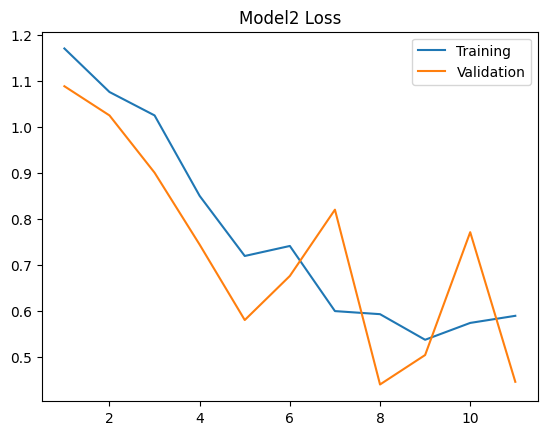

In [39]:
loss_2 = his_2.history["loss"]
val_loss_2 = his_2.history["val_loss"]
epochs = range(1, len(loss_2) + 1)

plt.plot(epochs, loss_2, label = "Training")
plt.plot(epochs, val_loss_2, label = "Validation")
plt.title("Model2 Loss")
plt.legend(loc = "best")
plt.show()

### **Model2 Accuracy Evaluation**

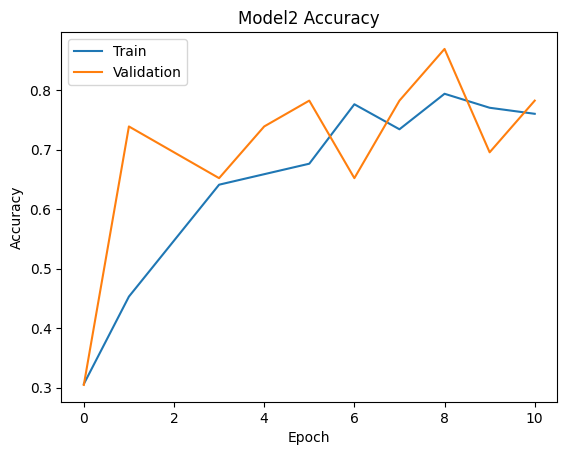

In [40]:
plt.plot(his_2.history['accuracy'])
plt.plot(his_2.history['val_accuracy'])
plt.title('Model2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [41]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 0s - loss: 0.2963 - accuracy: 0.9615 - 26ms/epoch - 26ms/step


We can observe from the plot and evaluation that our model  has improved compared to our previous model but overfits and still not good enough.

In [42]:
# Here we would get the output as probablities for each category
y_pred_2=model2.predict(X_test_normalized)

1/1 [==============================] - 0s 64ms/step


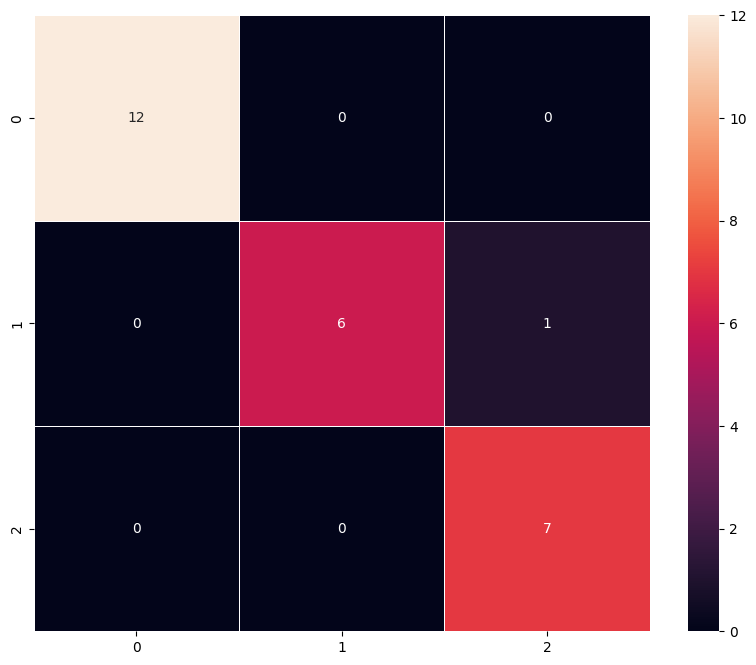

In [43]:
# # Obtaining the categorical values from y_test_encoded and y_pred
y_pred_2_arg=np.argmax(y_pred_2,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix2 = tf.math.confusion_matrix(y_test_arg,y_pred_2_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix2,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

# Transfer Learning using VGG16

In [44]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [45]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [46]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(64, activation='relu'))
new_model.add(Dropout(0.3))
new_model.add(Dense(32, activation='relu'))
new_model.add(Dense(3, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                131136    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 3)                 99        
                                                                 
Total params: 14848003 (56.64 MB)
Trainable params: 13

In [47]:
model3_filename = "/content/drive/MyDrive/Files/Data/Covid_19/Model/covid3.hdf5"
#es = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', verbose = 1)
chkpt3 = ModelCheckpoint(model3_filename, verbose = 1, save_best_only = True)
callbacks_list3 = [chkpt3, es]

In [48]:
# Epochs
epochs = 10
# Batch size
batch_size = 32

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1, callbacks = callbacks_list3)

Epoch 1/10
4/6 [===================>..........] - ETA: 0s - loss: 1.0334 - accuracy: 0.4906 
Epoch 1: val_loss improved from inf to 0.72876, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid3.hdf5
6/6 [==============================] - 4s 313ms/step - loss: 0.9656 - accuracy: 0.5529 - val_loss: 0.7288 - val_accuracy: 0.8261
Epoch 2/10
5/6 [========================>.....] - ETA: 0s - loss: 0.7378 - accuracy: 0.7029
Epoch 2: val_loss improved from 0.72876 to 0.59035, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid3.hdf5
6/6 [==============================] - 1s 90ms/step - loss: 0.7315 - accuracy: 0.7059 - val_loss: 0.5904 - val_accuracy: 0.7391
Epoch 3/10
5/6 [========================>.....] - ETA: 0s - loss: 0.6397 - accuracy: 0.7375
Epoch 3: val_loss improved from 0.59035 to 0.46548, saving model to /content/drive/MyDrive/Files/Data/Covid_19/Model/covid3.hdf5
6/6 [==============================] - 1s 102ms/step - loss: 0.6038 - accuracy: 0.7

### **Model3 Loss Evaluation**

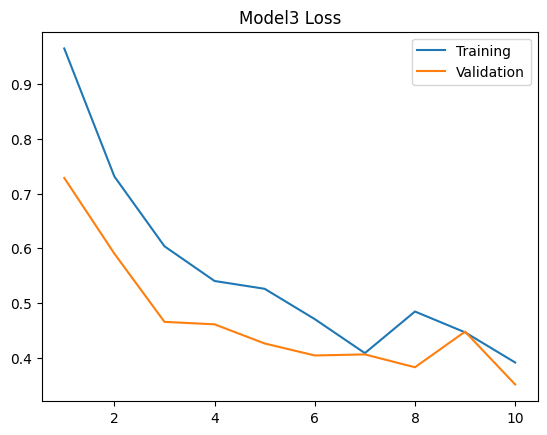

In [49]:
loss_vgg16 = history_vgg16.history["loss"]
val_loss_vgg16 = history_vgg16.history["val_loss"]
epochs = range(1, len(loss_vgg16) + 1)

plt.plot(epochs, loss_vgg16, label = "Training")
plt.plot(epochs, val_loss_vgg16, label = "Validation")
plt.title("Model3 Loss")
plt.legend(loc = "best")
plt.show()

### **Model3 Accuracy Evaluation**

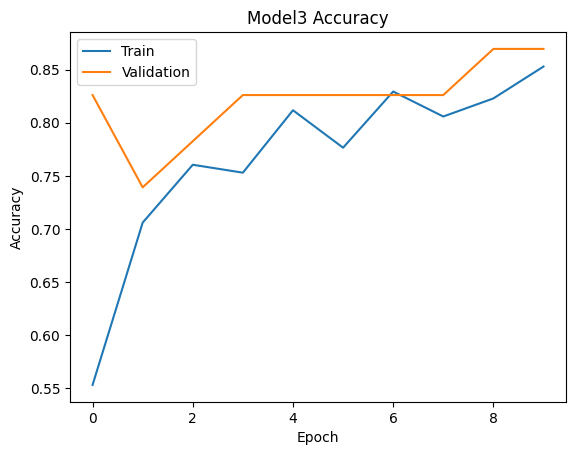

In [50]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [51]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 1s - loss: 0.3229 - accuracy: 0.8462 - 653ms/epoch - 653ms/step


In [52]:
# Here we would get the output as probablities for each category
y_pred_vgg16=new_model.predict(X_test_normalized)

1/1 [==============================] - 0s 162ms/step


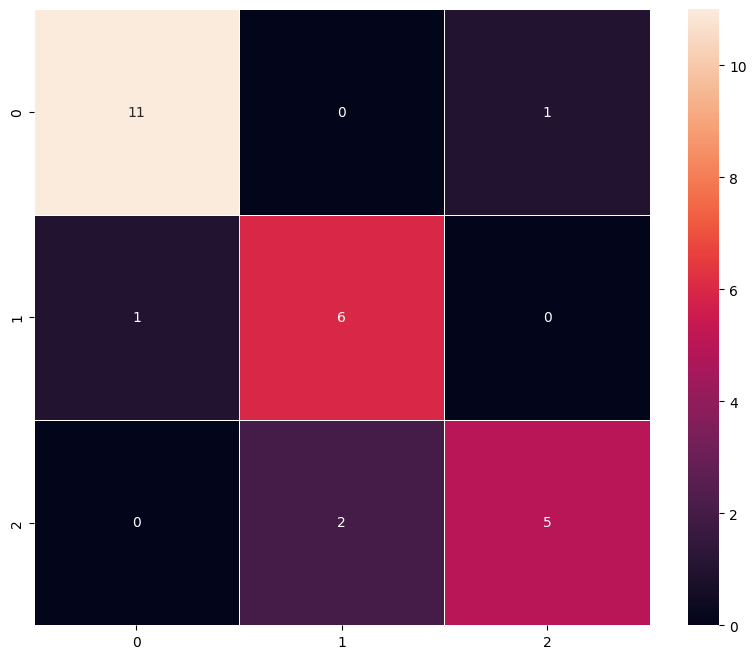

In [53]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_3_arg=np.argmax(y_pred_vgg16,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix3 = tf.math.confusion_matrix(y_test_arg,y_pred_3_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix3,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

- According to the confusion matrix and accuracy curve, the VGG16 model learned very well and generalizes appreciably compared to the Model-2, hence the VGG16 model would be our second best model to be used to predict and visualize our test images.


## **Visualizing the prediction:**

### *Model3*

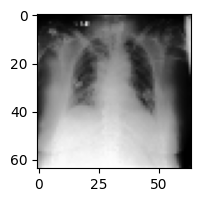

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Covid']
True Label Covid


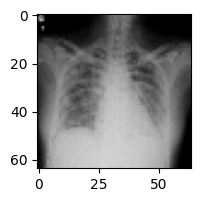

1/1 [==============================] - 0s 22ms/step
Predicted Label ['Covid']
True Label Covid


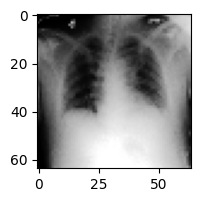

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Covid']
True Label Covid


In [55]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[3])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[3].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[3])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[1])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[1].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[1])                                              # using inverse_transform() to get the output label from the output vector

### *Model2*

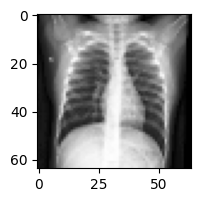

1/1 [==============================] - 0s 94ms/step
Predicted Label ['Viral Pneumonia']
True Label Normal


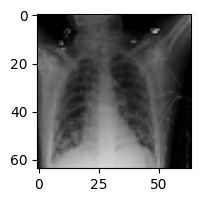

1/1 [==============================] - 0s 40ms/step
Predicted Label ['Covid']
True Label Covid


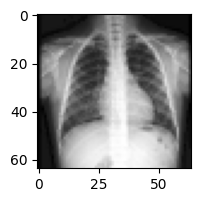

1/1 [==============================] - 0s 29ms/step
Predicted Label ['Normal']
True Label Normal


In [56]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[4])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[4].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[4])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[6])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[6].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[6])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[8])
plt.show()
print('Predicted Label', enc.inverse_transform(model2.predict((X_test_normalized[8].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[8])

### *Base Model*

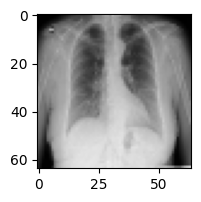

1/1 [==============================] - 0s 39ms/step
Predicted Label ['Covid']
True Label Covid


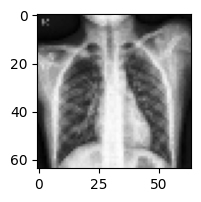

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Normal']
True Label Normal


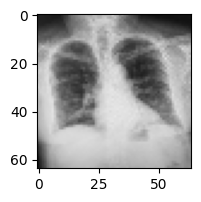

1/1 [==============================] - 0s 24ms/step
Predicted Label ['Covid']
True Label Covid


In [57]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[5])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[5].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[5])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[7])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[7].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[7])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[9])
plt.show()
print('Predicted Label', enc.inverse_transform(model.predict((X_test_normalized[9].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[9])

## Conclusion
- From the confusion matrix, loss curve, and accuracy curve of all the models trained, the base model(model1) learned most and turned out to be the best model hence got all its predictions were correctly.
- The test accuracy of the base model is 100%.
- Data Augmentation learned but not as much as the base model, it also failed to predict a class correctly.
- The transfer learning model learned well too but not as much as the base model.

- Since the assignment requires a deep learning model to be used by the users on our streamlit app, Model3 which the vgg16 model will be used.

In [58]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['98%','79%','85%'],'Validation Accuracy':['95%','86%','86%'],'Test Accuracy':['100%','96%','84%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,98%,95%,100%
1,CNN Model with Data Augmentation,79%,86%,96%
2,Transfer Learning Model,85%,86%,84%
